# Recitation 8: antithetic systems simulation

* Simulating a café with antithetic variance reduction

Consider a café where customers enter according to a homogeneous Poisson process with rate $\lambda$ and once they've purchased a thing, they queue up to sit at a table or, if the queue is too long, then they reneg (i.e. they leave and drink the coffee while walking back).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simpy

Time units in minutes

In [2]:
def uf():
    return np.random.rand()

In [3]:
# avg # customers per minute
lmbda = 10

service_lambda = 5.1
table_lambda = 1

# proportion of customers who want a table a priori
table_prob = 0.6

In [4]:
r = np.random.default_rng(12345)

In [5]:
r.uniform()

0.22733602246716966

In [6]:
total_rewards = []
runs = []

for run in range(300):
    runs.append((True, run))
    runs.append((False, run))

for antithetic, run in runs:
    np.random.seed(run)
    rngs = {
        "arrival": np.random.default_rng(np.random.randint(2**32)),
        "service": np.random.default_rng(np.random.randint(2**32)),
        "table1": np.random.default_rng(np.random.randint(2**32)),
        "table2": np.random.default_rng(np.random.randint(2**32)),
    }
    
    def gen(rng_name):
        # generates a uniform random number from the rng called rng_name and does 1-u if it's antithetic
        rng = rngs[rng_name]
        u = rng.uniform()
        if antithetic:
            return 1-u
        else:
            return u
    
#     print(run, antithetic)
    T = 60

    event_log = []

    number_of_tables = 5
    total_reward = 0. - 100.*number_of_tables*T/60

    def log(id_, msg):
        event_log.append((env.now, id_, msg))
#         print(f"{env.now:5.2f}: {msg}")

    def rand_exp(l, u=None):
        return -np.log(u or np.random.rand()) / l

    def service_proc():
        global service_lambda, table_lambda, total_reward
        # wait for a barista for service
        breq = baristas.request()
        log("wb", "Waiting for a barista")
        yield breq
        log("ws", "Waiting to be served")
        yield env.timeout(rand_exp(service_lambda, gen("service")))
        log("ds", "Got served")
        baristas.release(breq)
        # possibly wait for a table
        people_waiting_for_tables = len(tables.queue)
        if gen("table1") < table_prob and people_waiting_for_tables < number_of_tables:
            log("wt", "Decided to wait for table...")
            treq = tables.request()
            yield treq
            log("dc", "Got table... drinkin' ma coffee")
            yield env.timeout(rand_exp(table_lambda, gen("table2")))
            log("dd", "Done with the coffee")
            tables.release(treq)
            total_reward += 3.
        else:
            log("rt", "The queue was too long, and my hot coffee was going to get too cold")
            total_reward += 2.

    def arrival_proc():
        while True:
            inter_arrival_time = rand_exp(lmbda, u=gen("arrival"))
            yield env.timeout(inter_arrival_time)
            log("ar", "Hooray! Arrival.")
            env.process(service_proc())

    env = simpy.Environment()
    baristas = simpy.Resource(env, capacity=3)
    tables = simpy.Resource(env, capacity=5)
    env.process(arrival_proc())
    env.run(until=60)

    total_rewards.append((antithetic, run, total_reward))

In [7]:
normal_run_rew = [r for a, i, r in total_rewards if not a]
anti_run_rew = [r for a, i, r in total_rewards if a]

In [8]:
full_rew = (np.array(normal_run_rew) + np.array(anti_run_rew)) / 2

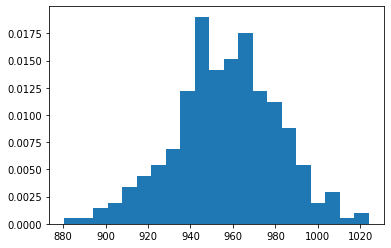

In [9]:
plt.hist(full_rew, density=True, bins=21);

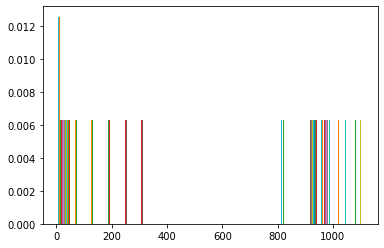

In [10]:
plt.hist(total_rewards, density=True, bins=21);

In [11]:
total_reward

917.0

In [12]:
baristas.queue

[]

In [13]:
arrival_times = [t for t, i, m in event_log if i == "ar"]

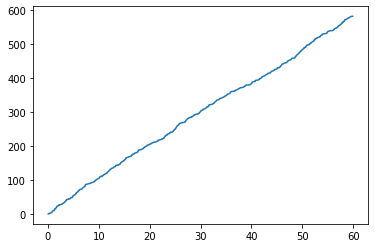

In [14]:
plt.plot(arrival_times, np.arange(len(arrival_times)))